# Best Business Recommendation

## Supporting Code, Connections & Packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

In [2]:
# Function to place Postgres query into Pandas dataframe

def query_pandas(query, rollback_before, rollback_after):
    
    if rollback_before:
        pgsql.rollback()
    
    df = pd.read_sql_query(query, pgsql)
    
    if rollback_after:
        pgsql.rollback()
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
# Connection to Postgres database

pgsql = psycopg2.connect(
    user = "redacted",
    password = "redacted",
    host = "redacted",
    port = "redacted",
    database = "redacted"
    )

In [4]:
cursor = pgsql.cursor()

# Prompt

Acme Gourmet Meals (AGM) is a company that specializes in healthy, gourmet quality meals freshly fixed in containers. Products are marketed and sold at high-end grocery stores in five locations (Berkeley, CA; Dallas, TX; Miami, Fl; Nashville, TN; and Seattle, WA).

Meals are sold at a flat rate of twelve dollars per meal with no minimum. Since the food has to be heated before eating, it is not subject to sales tax. Customers must order by 10 AM one day in order to pick up the meals the next day.

AGM has just finished a very successful year on the enhanced computer systems, and now has a database of sales data for one year.

#### The executives at AGM want a best recommendation for the business.

#### Create an executive summary giving and explaining a best recommendation for the business. 

# Executive Summary

AGM should consider expanding into new store locations or starting delivery services to be more proximate to loyal customers who live farther away, thus opening new market opportunities. After careful analysis, there appears to be a strong relationship between customer visits, customer sales and dollar sales amount. Combining this insight with exploration into customer density by distance suggests that there is upside in opening new store locations in certain cities at a radius of approximately 12-15 miles from the original location (Appendix 3.2.1).

Store expansion and delivery services are a great opportunities for AGM to grow its customer base. Based on an initial view of the dataset, customer visits have a direct impact on sales dollars (Appendix 2.1.1). First time purchases from customers in 2020 occurred up until April, meaning that most of the meal sales are made by repeat customers during the remainder of the year (Appendix 2.2). Increasing the number of first time purchases could open the possibility to more customers becoming frequent shoppers. This is true especially if stores are conveniently close by.

Shifting the analysis toward customer density by distance from a store, shops like Berkeley, Dallas, Nashville, and Seattle have comparable average customer densities both nearby and farther out. Each store should be viewed as individual cases. To calculate the average customer density, customers are grouped by home city and distance from store, with each home city paired to its area by square mile information from a secondary dataset. After determining the number of customers per square mile, each city's customer density is averaged across all cities that fall within a similar distance from a store.

Using the Berkeley store as an example, within the first three miles of the store location, the average customer density levels range from approximately 15-50 customers per square mile. At 14 miles out the average customer density sits at an estimated 35 customers per square mile. Other stores may be interpreted differently: in Seattle, for instance, the average density is around 12 customers per square mile at both four and twelve miles out.

Taking the average density by distance away from store, in conjunction with the correlation between store visits and sales, reveals an opportunity to increase customers and have products delivered or placed in more distant locations. Each store should be explored individually and evaluated based on the demographic and economic climate of the area.

# Data & Visualization Appendix

## 1. Variable & Data Preparation

In [5]:
store_list = ['Berkeley', 'Dallas', 'Miami', 'Nashville', 'Seattle']
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']

## 2. High-Level Customer & Sales Analysis

### 2.1 Measuring Total Sales and Number of Unique Customers by Month

The goal is to determine how customers and sales are related.

In [6]:
# Query to find total sales and unique customers by month

rollback_before = True
rollback_after = True

query = """

select city as store_name,
    to_char(sale_date, 'Month') as month_name,
    sum(total_amount)/1000 as total_sales,
    count(customer_id) as num_cust,
    count(distinct customer_id) as unique_cust
from stores s
    join sales sa on s.store_id = sa.store_id 
group by store_name, month_name, extract(month from sale_date)
order by 1, extract(month from sale_date)

"""

df_mo = query_pandas(query, rollback_before, rollback_after)
df_mo.head(10)

,store_name,month_name,total_sales,num_cust,unique_cust
0,Berkeley,January,1988.904,31045,7750
1,Berkeley,February,1930.272,30062,7718
2,Berkeley,March,2224.500,34704,7842
3,Berkeley,April,2092.056,32589,7797
4,Berkeley,May,2019.264,31485,7780
5,Berkeley,June,2065.140,32153,7769
6,Berkeley,July,2034.708,31582,7791
7,Berkeley,August,2286.732,35676,7871
8,Berkeley,September,1922.256,29876,7750
9,Berkeley,October,2248.008,35199,7879


#### 2.1.1 Sales Amount and Number of Unique Customers by Month Charts

The total sales amount is shown by the barplot, while the number of unique customers is represented by the black line.

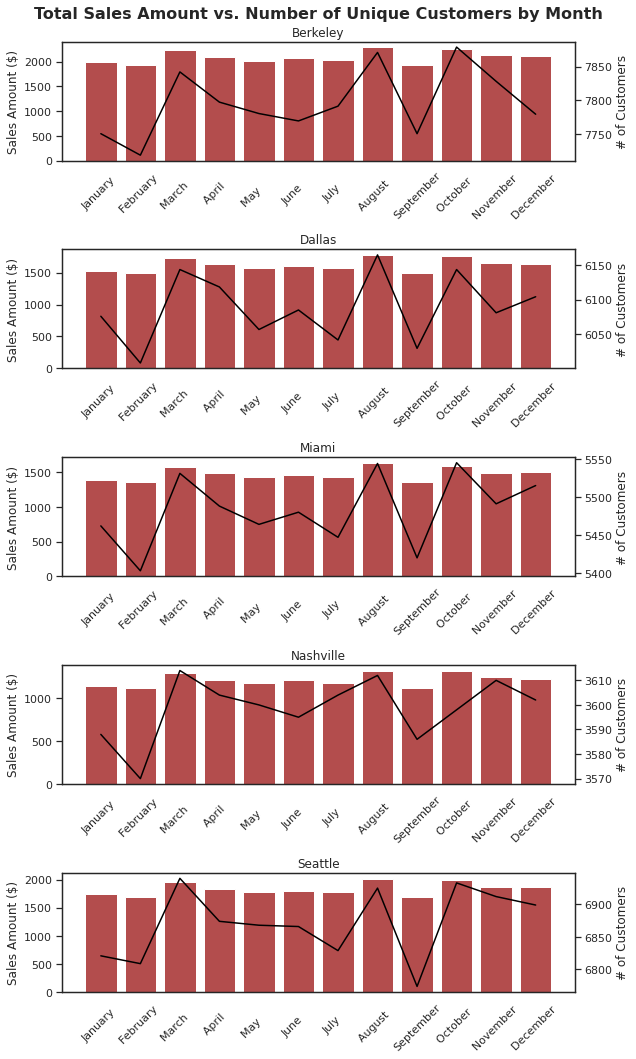

In [7]:
# Set function for plotting total sales vs. unique customers by month

def storemonth(df):
        
    sns.set(style='ticks')
    fig, axes = plt.subplots(5,1, figsize=(9,15))
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('Total Sales Amount vs. Number of Unique Customers by Month', fontweight='bold', 
                     fontsize=16)

    for st, ax in zip(store_list, axes.flatten()):
        df_st = df.loc[df['store_name'] == st]

        plo = sns.barplot(ax=ax, data=df_st, x='month_name', y='total_sales', 
                    color='red', saturation=0.4)
        ax.set(title=''+st+'', xlabel='', ylabel='Sales Amount ($)')
        ax.set_xticklabels(plo.get_xticklabels(), rotation=45)
        ax.tick_params(bottom=False)

        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, data=df_st, x=ax.get_xticks(), y='unique_cust', 
                        color='black')
        ax2.set(ylabel='# of Customers')
        ax2.grid(False)

        fig.tight_layout()

        pass

storemonth(df_mo)

### 2.2 Comparing Total Sales and With First Time Visits by Month (In 2020)

The next section looks at how sales compare with how often first time visits occur in 2020.

In [8]:
# Create view to show the first time all customers visited the store in 2020

pgsql.rollback()

query = """

drop view if exists first_visit_vw cascade
;

create view first_visit_vw
as
select customer_id,
    s.city as store_name,
    to_char(min(sale_date), 'Month') as first_visit,
    extract('Month' from min(sale_date)) as mo_num,
    cast(min(sale_date) as date) date
from sales sa
    join stores s on s.store_id = sa.store_id
group by customer_id, store_name
;

"""

cursor.execute(query)
pgsql.commit()

In [9]:
# Query to count the number of first time visits per month

rollback_before = True
rollback_after = True

query = """

select store_name,
first_visit as month_name,
count(date) as first_visit_num
from first_visit_vw
group by store_name, month_name, mo_num
order by store_name, mo_num

"""

df_new = query_pandas(query, rollback_before, rollback_after)
df_new.head(10)

,store_name,month_name,first_visit_num
0,Berkeley,January,7750
1,Berkeley,February,329
2,Berkeley,March,46
3,Berkeley,April,1
4,Dallas,January,6076
5,Dallas,February,259
6,Dallas,March,19
7,Dallas,April,1
8,Miami,January,5462
9,Miami,February,220


In [10]:
# Merge sales amount vs. unique customers dataframe with first visit dataframe

df_merg = pd.merge(df_mo, df_new, how='left', left_on=['store_name', 'month_name'], 
                      right_on = ['store_name', 'month_name'])

df_merg = df_merg.fillna(0)
df_merg.head(10)

,store_name,month_name,total_sales,num_cust,unique_cust,first_visit_num
0,Berkeley,January,1988.904,31045,7750,7750.0
1,Berkeley,February,1930.272,30062,7718,329.0
2,Berkeley,March,2224.500,34704,7842,46.0
3,Berkeley,April,2092.056,32589,7797,1.0
4,Berkeley,May,2019.264,31485,7780,0.0
5,Berkeley,June,2065.140,32153,7769,0.0
6,Berkeley,July,2034.708,31582,7791,0.0
7,Berkeley,August,2286.732,35676,7871,0.0
8,Berkeley,September,1922.256,29876,7750,0.0
9,Berkeley,October,2248.008,35199,7879,0.0


#### 2.2.1 Sales Amount and First Time Visits by Month Charts

The total sales amount is shown by the barplot, while the number of first time visits is represented by the blue line.

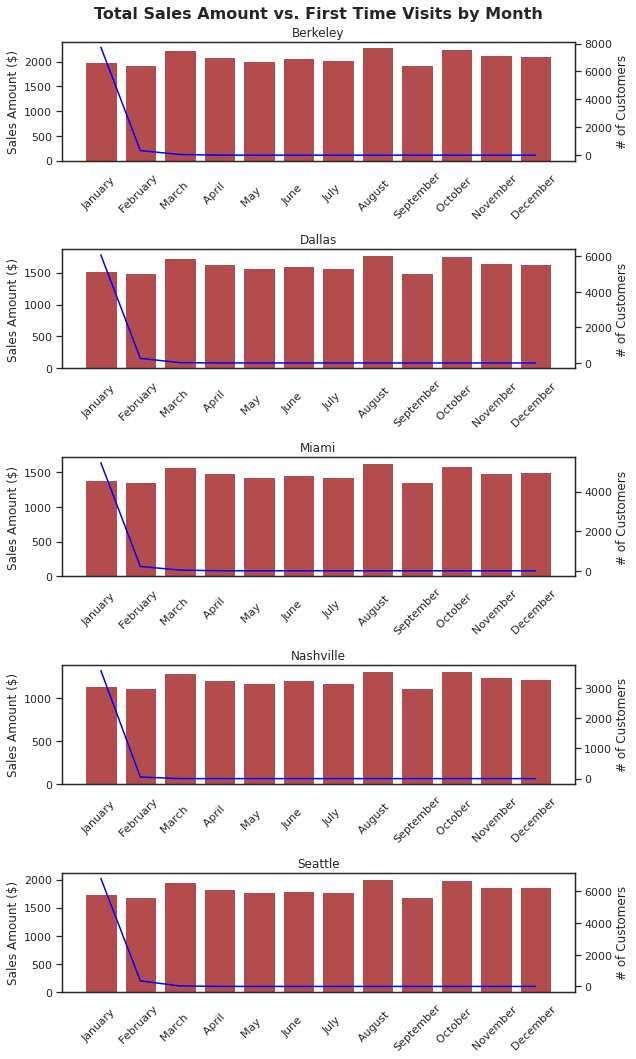

In [11]:
# Set function for plotting total sales vs. first time visits per month

def newcust(df):
        
    sns.set(style='ticks')
    fig, axes = plt.subplots(5,1, figsize=(9,15))
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('Total Sales Amount vs. First Time Visits by Month', fontweight='bold', 
                     fontsize=16)

    for st, ax in zip(store_list, axes.flatten()):
        df_st = df.loc[df['store_name'] == st]

        plo = sns.barplot(ax=ax, data=df_st, x='month_name', y='total_sales', 
                    color='red', saturation=0.4)
        ax.set(title=''+st+'', xlabel='', ylabel='Sales Amount ($)')
        ax.set_xticklabels(plo.get_xticklabels(), rotation=45)
        ax.tick_params(bottom=False)

        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, data=df_st, x=ax.get_xticks(), y='first_visit_num', 
                        color='blue')
        ax2.set(ylabel='# of Customers')
        ax2.grid(False)

        fig.tight_layout()

        pass


newcust(df_merg)

## 3. Customer Density Analysis

This analysis looks at the number of customers per square mile in the city they live in, and determines whether it has any impact on the distance to the closest store.

### 3.1 Customer Density by Store and Distance

In [12]:
# Create table with market saturation and customer density by city, store, and distance

pgsql.rollback()

query = """

drop table if exists cust_dens_tb cascade
;

create table cust_dens_tb
as
select c.city || ', ' || c.state as city_name,
    closest_store_id as store_id,
    distance,
    closest_store_id || '' || distance as storedist_id,
    count(c.customer_id) as num_customers,
    population,
    round((count(c.customer_id)/population) * 100, 2) as percent_customers,
    density,
    area,
    (count(c.customer_id)/area) as cust_dens
from customers c
    join cities ci on c.city = ci.city and c.state = ci.state
group by city_name, store_id, storedist_id, distance, population, density, area
order by cust_dens desc
;

"""

cursor.execute(query)

pgsql.commit()

In [13]:
# Query for average customer density by store and distance

rollback_before = True
rollback_after = True

query = """

select city as store_name,
    s.store_id as store_id,
    distance,
    (s.store_id || '' || distance) as storedist_id,
    round(avg(cust_dens), 2) as avg_dens
from cust_dens_tb t join stores s on s.store_id = t.store_id
group by store_name, s.store_id, distance, storedist_id
order by s.store_id, distance

"""

df_dist = query_pandas(query, rollback_before, rollback_after)
df_dist.head(10)

,store_name,store_id,distance,storedist_id,avg_dens
0,Berkeley,1,1,11,16.83
1,Berkeley,1,2,12,50.11
2,Berkeley,1,3,13,43.13
3,Berkeley,1,4,14,9.20
4,Berkeley,1,5,15,18.24
5,Berkeley,1,6,16,6.90
6,Berkeley,1,7,17,8.48
7,Berkeley,1,8,18,7.07
8,Berkeley,1,9,19,4.53
9,Berkeley,1,10,110,9.47


#### 3.1.1 Total Sales Amount by Store and Distance

In [14]:
# Query for total sales amount by store and distance

rollback_before = True
rollback_after = True

query = """

select closest_store_id as store_id,
    distance,
    closest_store_id || '' || distance as storedist_id,
    round(sum(total_amount)/1000, 2) as total_sales
from customers cu
    join sales sa on cu.customer_id = sa.customer_id
group by closest_store_id, distance, storedist_id

"""

df_sales = query_pandas(query, rollback_before, rollback_after)
df_sales.head(10)

,store_id,distance,storedist_id,total_sales
0,1,1,11,3128.81
1,1,2,12,2324.14
2,1,3,13,3027.78
3,1,4,14,2877.26
4,1,5,15,1677.26
5,1,6,16,1729.12
6,1,7,17,1138.37
7,1,8,18,1331.41
8,1,9,19,1450.08
9,1,10,110,1293.82


In [15]:
# Merge density and sales dataframes, cleanup columns

df_dist = df_dist.merge(df_sales, on='storedist_id')

df_dist = df_dist.drop(['store_id_y','distance_y', 'storedist_id'], axis=1)
df_dist = df_dist.rename(columns={'store_id_x':'store_id', 
                                    'distance_x':'distance'})

In [16]:
# Create rows for missing distances from the Nashville store

df_nash = pd.DataFrame()

df_nash['store_name'] = ['Nashville', 'Nashville', 'Nashville']
df_nash['store_id'] = [5, 5, 5]
df_nash['distance'] = [10, 15, 24]
df_nash['avg_dens'] = [0, 0, 0]
df_nash['total_sales'] = [0, 0, 0]

In [17]:
# Create rows for missing distances from the Miami store

df_miami = pd.DataFrame()

df_miami['store_name'] = ['Miami']
df_miami['store_id'] = [4]
df_miami['distance'] = [2]
df_miami['avg_dens'] = [0]
df_miami['total_sales'] = [0]

In [18]:
# Concatenate Nashville and Miami rows for plotting

df_join = [df_dist, df_nash, df_miami]
df_dist = pd.concat(df_join)

df_dist = df_dist.sort_values(['store_id', 'distance'])
df_dist = df_dist.reset_index(drop=True)

df_dist.head(10)

,store_name,store_id,distance,avg_dens,total_sales
0,Berkeley,1,1,16.83,3128.81
1,Berkeley,1,2,50.11,2324.14
2,Berkeley,1,3,43.13,3027.78
3,Berkeley,1,4,9.20,2877.26
4,Berkeley,1,5,18.24,1677.26
5,Berkeley,1,6,6.90,1729.12
6,Berkeley,1,7,8.48,1138.37
7,Berkeley,1,8,7.07,1331.41
8,Berkeley,1,9,4.53,1450.08
9,Berkeley,1,10,9.47,1293.82


#### 3.1.2 Plots Comparing Customer Density vs. Sales Amount by Distance

The average customer density is shown by the barplot, and the number of total sales amount is represented by the black line.

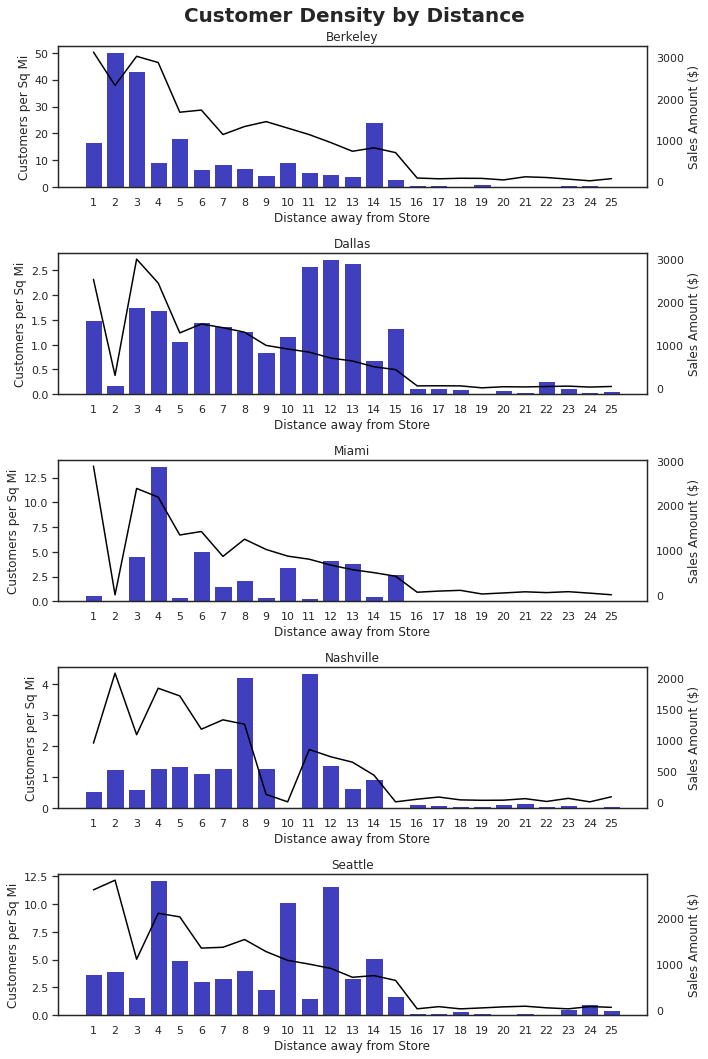

In [19]:
# Function to plot customer density by distance and store

def distchart(df):

    sns.set(style='ticks')
    fig, axes = plt.subplots(5,1, figsize=(10,15))
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('Customer Density by Distance', fontweight='bold', 
                     fontsize=20)

    for s, ax in zip(store_list, axes.flatten()):
        df_st = df.loc[df['store_name'] == s]

        sns.barplot(ax=ax, data=df_st, x='distance', y='avg_dens', 
                    color='blue', saturation=0.5)
        ax.set(title=''+s+'', xlabel='Distance away from Store', ylabel='Customers per Sq Mi')
        ax.tick_params(bottom=False)

        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, data=df_st, x=ax.get_xticks(), y='total_sales', 
                        color='black')
        ax2.set(ylabel='Sales Amount ($)')
        ax2.tick_params(right=False)
        ax2.grid(False)

        fig.tight_layout()

        pass
        

distchart(df_dist)

## 4. Market Saturation

### 4.1 Market Saturation by Distance

For market saturation, the number of customers within their home city population is calculated, before being averaged out by distance from store. 

In [20]:
# Query for average market saturation by store and distance

rollback_before = True
rollback_after = True

query = """

select store_id,
distance,
storedist_id,
round(avg(percent_customers), 2) as percent_customers
from cust_dens_tb
group by store_id, distance, storedist_id
order by storedist_id

"""

df_sat = query_pandas(query, rollback_before, rollback_after)
df_sat.head(10)

,store_id,distance,storedist_id,percent_customers
0,1,1,11,0.23
1,1,10,110,0.15
2,1,11,111,0.21
3,1,12,112,0.17
4,1,13,113,0.39
5,1,14,114,0.49
6,1,15,115,0.09
7,1,16,116,0.02
8,1,17,117,0.14
9,1,18,118,0.03


### 4.2 Market Saturation Below and Above a 12-Mile Distance

The table below calculates the average market saturation for all distances below and above 12 miles. Based on the customer density analysis, 12 miles is roughly a good starting point to think about where to open a new store location or how far to deliver food.

In [21]:
# Average percentage customer market saturation below and above 12-mile point

rollback_before = True
rollback_after = True

query = """

select city,
round(avg(case when distance <= 12 then percent_customers end), 2) as below_12_mi,
round(avg(case when distance > 12 then percent_customers end), 2) as above_12_mi
from cust_dens_tb t
    join stores s on t.store_id = s.store_id
group by city, s.store_id
order by city, s.store_id

"""

df_test = query_pandas(query, rollback_before, rollback_after)
df_test

,city,below_12_mi,above_12_mi
0,Berkeley,0.28,0.15
1,Dallas,0.08,0.03
2,Miami,0.09,0.01
3,Nashville,0.20,0.13
4,Seattle,0.15,0.12
